In [4]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import os
import warnings
import h5py
from collections import Counter, defaultdict
from sklearn.linear_model import Ridge, RidgeClassifier
from sklearn.model_selection import KFold, cross_val_score, ShuffleSplit, LeaveOneOut
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='notebook', style='white', rc={"font.family": "DejaVu Serif"})

# Load, format, and regress data

## Spike decoding method

In [5]:
def load_spikes_hdf5(filename):
    spikes = {}
    with h5py.File(filename, "r") as f:
        for label in f.keys():
            spikes[label] = {}
            for trial in f[label].keys():
                spikes[label][int(trial)] = f[label][trial][:]
    return spikes

In [6]:
def regress_spikes_block_binned(
        variables, data_type, alpha=1.0, spike_label='choice',
        random_state=42, downsample=True):

    rng = np.random.default_rng(seed=random_state)
    predictions = []

    for monkey in ['V', 'W']:
        for session in range(4):

            print(f"\n=== Starting monkey {monkey}, session {session} ===")
            session_data = {}   # stores only binned spike vectors

            # ---------------------------------------------------
            # Downsample NEF neurons once per session
            # ---------------------------------------------------
            if data_type == 'nef' and downsample:
                emp_file = f"data/emp/monkey{monkey}_session{session}_block1_spikes.h5"
                x_monkey = load_spikes_hdf5(emp_file)['choice'][1]
                nef_file = f"data/nef/monkey{monkey}_session{session}_block1_spikes.h5"
                spikes_nef = load_spikes_hdf5(nef_file)
                X_nef = spikes_nef[spike_label][1]
                idx_random = rng.choice(X_nef.shape[1], size=x_monkey.shape[1], replace=False)

            # ---------------------------------------------------
            # Load each block (monkey or NEF) and store trial-wise binned spikes
            # ---------------------------------------------------
            for block in range(1, 25):
                print(f"  Loading block {block} ...", end="")
                try:
                    session_data[block] = {}

                    # Load spike block
                    if data_type == 'nef':
                        spike_file = f"data/nef/monkey{monkey}_session{session}_block{block}_spikes.h5"
                        spikes_block = load_spikes_hdf5(spike_file)
                        val_file = f"data/nef/monkey{monkey}_session{session}_block{block}_values.pkl"
                        values_block = pd.read_pickle(val_file)

                    elif data_type == 'monkey':
                        spike_file = f"data/emp/monkey{monkey}_session{session}_block{block}_spikes.h5"
                        spikes_block = load_spikes_hdf5(spike_file)
                        val_file = f"data/rl/monkey{monkey}_session{session}_block{block}_values.pkl"
                        values_block = pd.read_pickle(val_file)

                    # Iterate over trials in the block
                    for trial in sorted(spikes_block[spike_label].keys()):
                        X = spikes_block[spike_label][trial]  # (num_bins × neurons)
                        if downsample and data_type == 'nef':
                            X = X[:, idx_random]

                        y_row = values_block.query("trial == @trial")
                        y_dict = {v: y_row[v].values[0] for v in variables}

                        session_data[block][trial] = (list(X), y_dict)  # list of binned vectors

                    print(" OK")

                except Exception as e:
                    print(f" FAILED ({e})")
                    session_data[block] = None

            # Remove incomplete blocks
            session_data = {b: d for b, d in session_data.items() if d and len(d) > 0}
            blocks = sorted(session_data.keys())
            print(f"  Valid blocks: {blocks}")

            if len(blocks) < 2:
                print("  Not enough blocks for LOO; skipping session.")
                continue

            # ---------------------------------------------------
            # Leave-One-Out CV using precomputed binned spikes
            # ---------------------------------------------------
            loo = LeaveOneOut()
            for fold_idx, (train_idx, test_idx) in enumerate(loo.split(blocks)):
                train_blocks = [blocks[i] for i in train_idx]
                test_blocks = [blocks[i] for i in test_idx]

                print(f"\n  --- LOO fold {fold_idx+1}/{len(blocks)} ---")
                print(f"      Training on blocks: {train_blocks}")
                print(f"      Testing on block: {test_blocks}")

                X_train = []
                Y_train = {v: [] for v in variables}

                for block in train_blocks:
                    for trial, (binned_spikes, y_dict) in session_data[block].items():
                        # Train on middle bin(s)
                        num_bins = len(binned_spikes)
                        mid_start = num_bins / 2 - 0.5
                        mid_end = num_bins / 2 + 0.5

                        for b in range(num_bins):
                            if mid_start <= b <= mid_end:
                                X_train.append(binned_spikes[b])
                                for v in variables:
                                    Y_train[v].append(y_dict[v])

                # Convert X_train to array once
                X_train = np.array(X_train)
                
                # Train models, removing NaNs in y
                models = {}
                for v in variables:
                    y = np.array(Y_train[v])
                    not_nan = ~np.isnan(y)
                    X_train_clean = X_train[not_nan]
                    y_clean = y[not_nan]
                
                    model = make_pipeline(StandardScaler(), Ridge(alpha=alpha))
                    model.fit(X_train_clean, y_clean)
                    models[v] = model

                # ---------------------------------------------------
                # Predict on test blocks (all bins)
                # ---------------------------------------------------
                for block in test_blocks:
                    for trial, (binned_spikes, y_dict) in session_data[block].items():
                        for b, spike_vec in enumerate(binned_spikes):
                            row = {"monkey": monkey,"session": session,"block": block,"trial": trial, "bin": b}
                            for v in variables:
                                row[v] = models[v].predict([spike_vec])[0]
                            predictions.append(row)

            print(f"\n=== Finished monkey {monkey}, session {session} ===")

    df_pred = (pd.DataFrame(predictions)
               .sort_values(['monkey', 'session', 'block', 'trial', 'bin'])
               .reset_index(drop=True))

    print("\nAll decoding complete.")
    return df_pred

In [7]:
monkey_values_cv_bins = regress_spikes_block_binned(variables=['DeltaV_Stim', 'DeltaV_Act', 'omega'], data_type='monkey', spike_label='choice')


=== Starting monkey V, session 0 ===
  Loading block 1 ... OK
  Loading block 2 ... OK
  Loading block 3 ... OK
  Loading block 4 ... OK
  Loading block 5 ... OK
  Loading block 6 ... OK
  Loading block 7 ... OK
  Loading block 8 ... OK
  Loading block 9 ... OK
  Loading block 10 ... OK
  Loading block 11 ... OK
  Loading block 12 ... OK
  Loading block 13 ... OK
  Loading block 14 ... OK
  Loading block 15 ... OK
  Loading block 16 ... OK
  Loading block 17 ... OK
  Loading block 18 ... OK
  Loading block 19 ... OK
  Loading block 20 ... OK
  Loading block 21 ... OK
  Loading block 22 ... OK
  Loading block 23 ... OK
  Loading block 24 ... OK
  Valid blocks: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]

  --- LOO fold 1/24 ---
      Training on blocks: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
      Testing on block: [1]

  --- LOO fold 2/24 ---
      Training on blocks: [1, 3, 4, 5, 6, 7, 8, 9, 10,

In [8]:
nef_pred_cva_bins = regress_spikes_block_binned(variables=['dvs', 'dva', 'omega'], data_type='nef', spike_label='a')


=== Starting monkey V, session 0 ===
  Loading block 1 ... OK
  Loading block 2 ... OK
  Loading block 3 ... OK
  Loading block 4 ... OK
  Loading block 5 ... OK
  Loading block 6 ... OK
  Loading block 7 ... OK
  Loading block 8 ... FAILED ([Errno 2] Unable to synchronously open file (unable to open file: name = 'data/nef/monkeyV_session0_block8_spikes.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0))
  Loading block 9 ... OK
  Loading block 10 ... OK
  Loading block 11 ... OK
  Loading block 12 ... FAILED ([Errno 2] Unable to synchronously open file (unable to open file: name = 'data/nef/monkeyV_session0_block12_spikes.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0))
  Loading block 13 ... FAILED ([Errno 2] Unable to synchronously open file (unable to open file: name = 'data/nef/monkeyV_session0_block13_spikes.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0))
  Loading block 

In [9]:
def load_rl_values():
    dfs = []
    variables = ['DeltaV_Stim', 'DeltaV_Act', 'DV_left', 'DV_right', 'omega']
    columns = ['monkey', 'session', 'block', 'trial'] + variables
    regression_dict = {}
    for monkey in ['V', 'W']:
        for session in range(4):
            for block in range(1,25):
                for trial in range(1, 81):
                    file = f"monkey{monkey}_session{session}_block{block}_trial{trial}"
                    try:
                        values = pd.read_pickle(f'data/rl/{file}_values.pkl')
                        cols = [monkey, session, block, trial]
                        for var in variables:
                            cols.append(values[var].values[0])
                        dfs.append(pd.DataFrame([cols], columns=columns))
                    except:
                        pass
    rl_values = pd.concat(dfs, ignore_index=True)
    return rl_values

In [10]:
rl_values = load_rl_values()

In [11]:
def load_nef_values(load=False, monkeys=['V', 'W'], sessions=range(4), blocks=range(1,25)):
    if load:
        nef_values = pd.read_pickle("data/nef_values.pkl")
    else:
        emp = pd.read_pickle("data/empirical.pkl")
        nef_dfs = []
        rl_dfs = []
        for monkey in monkeys:
            for session in sessions:
                for block in blocks:
                    try:
                        file = f"monkey{monkey}_session{session}_block{block}"
                        nef_dfs.append(pd.read_pickle(f'data/nef/{file}_values.pkl').query("perturb==0.0"))
                    except:
                        pass
        nef_values = pd.concat(nef_dfs, ignore_index=True)
        nef_values.to_pickle("data/nef_values.pkl")
    return nef_values

In [12]:
nef_values = load_nef_values(False)
nef_values['model_type'] = 'nef'
# nef_values.rename(columns={'w': 'omega'}, inplace=True)

# Plot P(better) and omega vs time

In [13]:
def add_columns(monkey_values, rl_values):
    emp = pd.read_pickle("data/empirical.pkl").copy()
    emp['trial_rev'] = emp['trial'].astype('int64') - emp['reversal_at_trial'].astype('int64')
    emp.rename(columns={'monkey_choice': 'cloc'}, inplace=True)
    emp.rename(columns={'monkey_accuracy': 'acc'}, inplace=True)
    emp.rename(columns={'reward': 'rew'}, inplace=True)
    emp['rew'] = emp['rew'].replace(0, -1)
    emp['cloc'] = emp['cloc'].replace('left', 0)
    emp['cloc'] = emp['cloc'].replace('right', 1)
    
    monkey_values = pd.merge(
        monkey_values,
        emp[["monkey", "session", "block", "trial", "block_type", "rew", "cloc", "clet", "acc", "trial_rev"]],
        # emp[["monkey", "session", "block", "trial", "block_type", "trial_rev", 'acc']],
        on=["monkey", "session", "block", "trial"],
        how="left"  # keeps all df1 rows, fills missing df2 values with NaN
    )
    monkey_values = monkey_values.dropna().reset_index(drop=True)

    rl_values = pd.merge(
        rl_values,
        emp[["monkey", "session", "block", "trial", "block_type", "trial_rev"]],
        on=["monkey", "session", "block", "trial"],
        how="left"  # keeps all df1 rows, fills missing df2 values with NaN
    )
    rl_values['model_type'] = 'rl'

    return monkey_values, rl_values

In [14]:
def smooth_split(df, y, ylabel, window=10):
    # Apply smoothing to trials on each side of the reversal independently
    left = df[df['trial_rev'] < 0].copy()
    right = df[df['trial_rev'] >= 0].copy()
    left[ylabel] = (left[y].rolling(window=window, center=True, min_periods=1).mean())
    right[ylabel] = (right[y].rolling(window=window, center=True, min_periods=1).mean())
    return pd.concat([left, right]).sort_index()

In [15]:
def plot_dynamics(monkey, nef, y, xlim=[-40,40], ylim=[0,1], yticks=5, ylabel='ylabel', filename='filename'):
    group_cols = ['monkey', 'session', 'block']
    monkey = monkey.sort_values(group_cols + ['trial'])
    nef = nef.sort_values(group_cols + ['trial'])

    monkey[f'{y}_smooth'] = (
        monkey.groupby(group_cols, group_keys=False)
        .apply(lambda g: smooth_split(g.drop(columns=group_cols), y=y, ylabel=f'{y}_smooth'))[f'{y}_smooth']
    )

    nef[f'{y}_smooth'] = (
        nef.groupby(group_cols, group_keys=False)
        .apply(lambda g: smooth_split(g.drop(columns=group_cols), y=y, ylabel=f'{y}_smooth'))[f'{y}_smooth']
    )

    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True, figsize=(8, 4))
    sns.lineplot(monkey, x='trial_rev', y=f'{y}_smooth', hue='block_type', style='monkey',
                palette=[palette[3], palette[0]], ax=axes[0],
                hue_order=['what', 'where'], style_order=['V', 'W'])
    sns.lineplot(nef, x='trial_rev', y=f'{y}_smooth', hue='block_type', style='monkey',
                palette=[palette[3], palette[0]], ax=axes[1],
                hue_order=['what', 'where'], style_order=['V', 'W'])

    axes[0].set(ylabel=ylabel, xlabel='Trial', title='Monkey', xlim=xlim, ylim=ylim, yticks=np.linspace(ylim[0], ylim[1], yticks))
    axes[1].set(xlabel='Trial', title='NEF')
    # axes[0].axhline(0.5, ls=':', color='k')
    # axes[1].axhline(0.5, ls=':', color='k')
    axes[0].axvline(0, ls=':', color='k')
    axes[1].axvline(0, ls=':', color='k')
    axes[0].get_legend().remove()
    plt.legend(ncol=2)
    fig.tight_layout()
    plt.show()
    fig.savefig(f"plots/{filename}.pdf")

In [17]:
monkey_values_rev, rl_values_rev = add_columns(monkey_values_cv_bins.query("bin==15"), rl_values)

/tmp/ipykernel_237930/4062420662.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  emp['cloc'] = emp['cloc'].replace('right', 1)


/tmp/ipykernel_237930/4204626537.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: smooth_split(g.drop(columns=group_cols), y=y, ylabel=f'{y}_smooth'))[f'{y}_smooth']
/tmp/ipykernel_237930/4204626537.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: smooth_split(g.drop(columns=group_cols), y=y, ylabel=f'{y}_smooth'))[f'{y}_smooth']


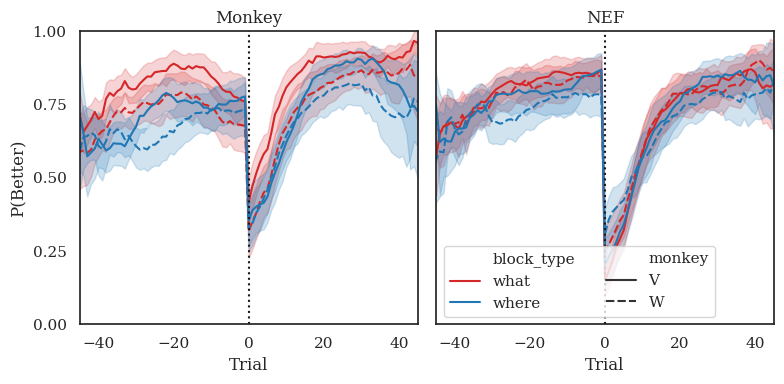

In [18]:
plot_dynamics(monkey_values_rev, nef_values, y='acc', xlim=[-45,45], ylabel='P(Better)', filename="Pbetter_vs_trial")

/tmp/ipykernel_237930/4204626537.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: smooth_split(g.drop(columns=group_cols), y=y, ylabel=f'{y}_smooth'))[f'{y}_smooth']
/tmp/ipykernel_237930/4204626537.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: smooth_split(g.drop(columns=group_cols), y=y, ylabel=f'{y}_smooth'))[f'{y}_smooth']


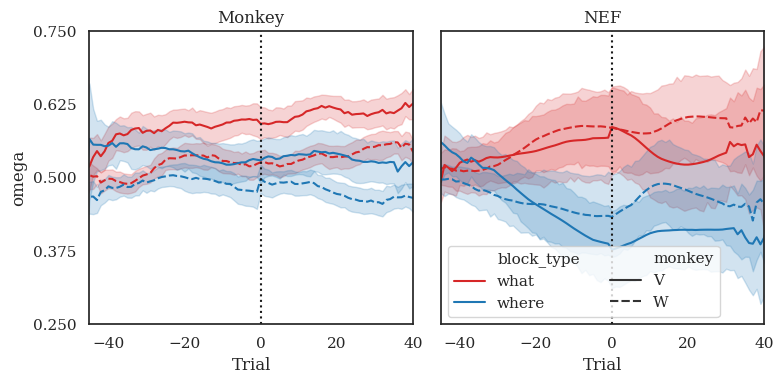

In [19]:
plot_dynamics(monkey_values_rev, nef_values, y='omega', xlim=[-45,40], ylim=[0.25, 0.75], ylabel='omega', filename="omega_vs_trial")

# Plot fraction of Q_total vs omega

In [20]:
def plot_fraction_Qtotal(nef_values, rl_values, monkey_values):
    nef_w = nef_values['omega'].to_numpy()
    nef_dvs = np.abs(nef_values['va'].to_numpy() - nef_values['vb'].to_numpy())
    nef_dva = np.abs(nef_values['vl'].to_numpy() - nef_values['vr'].to_numpy())
    nef_p_stim = nef_dvs / (nef_dvs + nef_dva)
    nef_p_act = nef_dva / (nef_dvs + nef_dva)
    
    rl_w = rl_values['omega'].to_numpy()
    rl_dvs = np.abs(rl_values['DeltaV_Stim'].to_numpy())
    rl_dva = np.abs(rl_values['DeltaV_Act'].to_numpy())
    rl_p_stim = rl_dvs / (rl_dvs + rl_dva)
    rl_p_act = rl_dva / (rl_dvs + rl_dva)
    
    monkey_w = monkey_values['omega'].to_numpy()
    monkey_dvs = np.abs(monkey_values['DeltaV_Stim'].to_numpy())
    monkey_dva = np.abs(monkey_values['DeltaV_Act'].to_numpy())
    monkey_p_stim = monkey_dvs / (monkey_dvs + monkey_dva)
    monkey_p_act = monkey_dva / (monkey_dvs + monkey_dva)
    
    w_bins = np.linspace(0, 1, 20)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6,3), sharex=True, sharey=True)
    sns.regplot(x=rl_w, y=rl_p_stim, x_bins=w_bins, ax=axes[0], color=palette[0], scatter_kws={"s": 1}, label='RL')
    sns.regplot(x=rl_w, y=rl_p_act, x_bins=w_bins, ax=axes[1], color=palette[0], scatter_kws={"s": 1}, label='RL')
    sns.regplot(x=nef_w, y=nef_p_stim, x_bins=w_bins, ax=axes[0], color=palette[1], scatter_kws={"s": 1}, label='NEF')
    sns.regplot(x=nef_w, y=nef_p_act, x_bins=w_bins, ax=axes[1], color=palette[1], scatter_kws={"s": 1}, label='NEF')
    sns.regplot(x=monkey_w, y=monkey_p_stim, x_bins=w_bins, ax=axes[0], color=palette[2], scatter_kws={"s": 1}, label='Monkey')
    sns.regplot(x=monkey_w, y=monkey_p_act, x_bins=w_bins, ax=axes[1], color=palette[2], scatter_kws={"s": 1}, label='Monkey')
    axes[0].set(ylabel=r"Fraction of $Q_{total}$", xlim=(0.2, 0.8), ylim=(0.2, 0.8), title=r"$Q_{stim}$", xlabel=r'$\omega$')
    axes[1].set(xlim=(0.2, 0.8), ylim=(0.2, 0.8), title=r"$Q_{loc}$", xlabel=r'$\omega$')
    axes[0].legend()
    plt.tight_layout()
    fig.savefig("plots/qtotal_vs_omega.pdf")

/tmp/ipykernel_237930/3740080227.py:11: RuntimeWarning: invalid value encountered in divide
  rl_p_stim = rl_dvs / (rl_dvs + rl_dva)
/tmp/ipykernel_237930/3740080227.py:12: RuntimeWarning: invalid value encountered in divide
  rl_p_act = rl_dva / (rl_dvs + rl_dva)


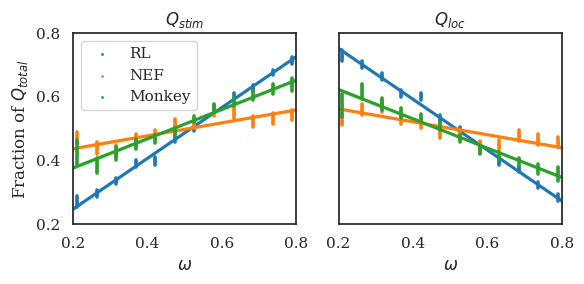

In [23]:
plot_fraction_Qtotal(nef_values, rl_values, monkey_values_cv_bins.query("bin==15"))

# Plot decoding acccuracy vs omega

In [29]:
def plot_decoding_accuracy_vs_time_seaborn(predicted_df, true_df, data_type='monkey', filename='filename'):

    if data_type == 'monkey':
        vars_dec = ['DeltaV_Act', 'DeltaV_Stim']
        ylabel = 'Monkey Decoding Accuracy\n'+r'(cross-validated $R^2$)'
    elif data_type == 'nef':
        vars_dec = ['dva', 'dvs']
        ylabel = 'NEF Decoding Accuracy\n'+r'(cross-validated $R^2$)'
    else:
        raise ValueError("data_type must be 'monkey' or 'nef'")

    pretty = {'DeltaV_Act': r'$\Delta Q_{Act}$', 'DeltaV_Stim': r'$\Delta Q_{Stim}$', 'dva': r'$\Delta V_{Act}$', 'dvs': r'$\Delta V_{Stim}$'}

    df_true = true_df.copy()
    df_true['omega_bin'] = pd.qcut(df_true['omega'], q=5, labels=False) + 1

    combined = pd.merge(df_true[['monkey','session','block','trial','omega','omega_bin'] + vars_dec], predicted_df[['monkey','session','block','trial','bin'] + vars_dec], on=['monkey','session','block','trial'], suffixes=('_true','_pred'))
    
    rows = []
    for omega_bin in sorted(combined['omega_bin'].unique()):
        df_omega = combined.query("omega_bin == @omega_bin")
        for bin_idx in sorted(df_omega['bin'].unique()):
            df_tb = df_omega[df_omega['bin'] == bin_idx]
            for var in vars_dec:
                col_true = f"{var}_true"
                col_pred = f"{var}_pred"
                y_true = df_tb[col_true].values
                y_pred = df_tb[col_pred].values
                if len(y_true) > 1 and not np.all(np.isnan(y_true)) and not np.all(np.isnan(y_pred)):
                    r2 = r2_score(y_true, y_pred)
                else:
                    r2 = np.nan
                rows.append({'variable': var, 'omega_bin': omega_bin, 'bin': bin_idx, 'r2': r2})

    r2_df = pd.DataFrame(rows)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

    palette = sns.color_palette("coolwarm", 5)

    for i, var in enumerate(vars_dec):
        ax = axes[i]
        sns.lineplot(data=r2_df[r2_df['variable'] == var], x='bin', y='r2', hue='omega_bin', palette=palette, linewidth=2, marker='o', ax=ax)
        ax.set_title(pretty[var], fontsize=14)
        ax.set_xlabel("Time bin", fontsize=12)
        if i == 0:
            ax.set_ylabel(ylabel, fontsize=12)
        else:
            ax.set_ylabel("")
        handles, labels = ax.get_legend_handles_labels()
        new_labels = [rf'$\omega_{{{lab}}}$' for lab in labels[1:]]
        ax.legend(handles[1:], new_labels, title=r'$\omega$ bin')
        ax.set(ylim=[-1,1])

    plt.tight_layout()
    plt.show()
    fig.savefig(f"plots/{filename}.pdf")

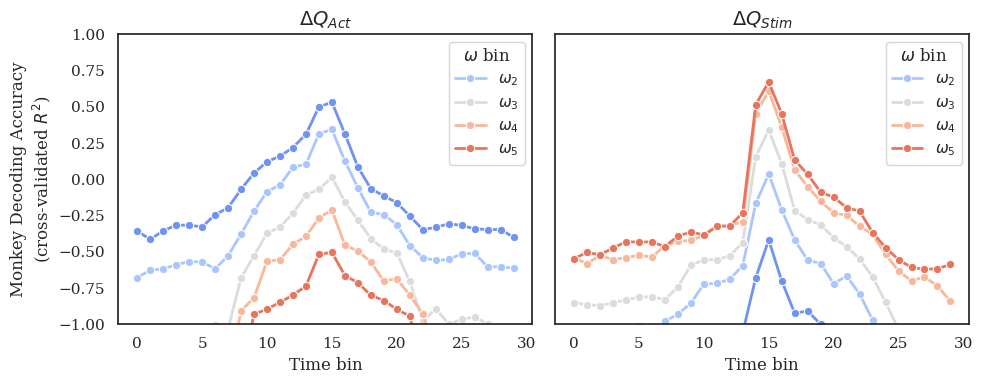

In [30]:
plot_decoding_accuracy_vs_time_seaborn(monkey_values_cv_bins, rl_values, filename="monkey_cross_decoding")

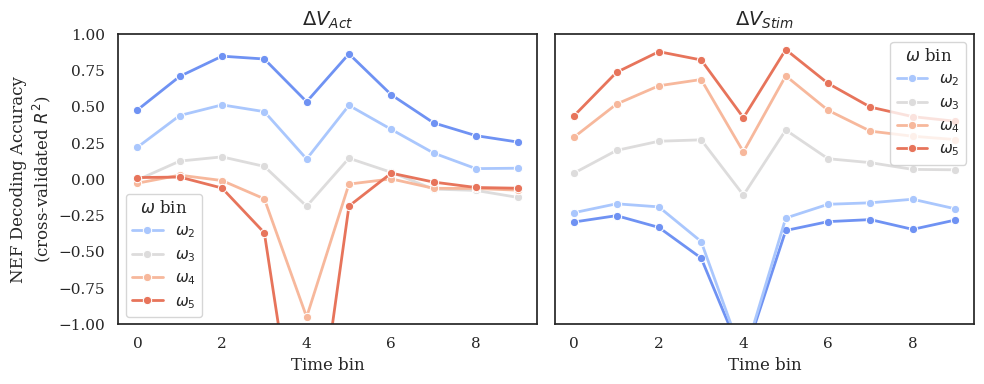

In [31]:
plot_decoding_accuracy_vs_time_seaborn(nef_pred_cva_bins, nef_values, data_type='nef', filename="nef_cross_decoding")